In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.ticker import FormatStrFormatter

pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
#CONSTANTS

# to do: change the rates so that there are company specific values as well (for 2019, need Via rates), maybe store in a dataframe

NON_WAV_PER_MILE_22 = 1.161
NON_WAV_PER_MIN_22 = 0.529

WAV_PER_MILE_22 = 1.504
WAV_PER_MIN_22 = 0.529

OUT_CITY_NON_WAV_PER_MILE_22 = 1.348
OUT_CITY_WAV_PER_MILE_22 = 1.746
OUT_CITY_PER_MIN_22 = 0.613


NON_WAV_PER_MILE_19 = 1.088
NON_WAV_PER_MIN_19 = 0.495

WAV_PER_MILE_19 = 1.410
WAV_PER_MIN_19 = 0.495

OUT_CITY_NON_WAV_PER_MILE_19 = 1.262
OUT_CITY_WAV_PER_MILE_19 = 1.636
OUT_CITY_PER_MIN_19 = 0.574

JUNO = "HV0002"
UBER = "HV0003"
VIA = "HV0004"
LYFT = "HV0005"

# February 2019 (not adjusted)

In [ ]:
# Import Cleaned Data

rides2019 = pq.read_table("../Aya_NYTWA/Data/february_2019_cleaned.parquet", memory_map=True).to_pandas()

In [ ]:
# Create minimum rates 2019 based on WAV and Out of City Conditions

conditions2019 = [
    (rides2019['wav_match_flag'] == 'N') & (rides2019['out_of_city'] == False),
    (rides2019['wav_match_flag'] == 'Y') & (rides2019['out_of_city'] == False),
    (rides2019['wav_match_flag'] == 'N') & (rides2019['out_of_city'] == True),
    (rides2019['wav_match_flag'] == 'Y') & (rides2019['out_of_city'] == True)]

choices2019 = [rides2019.trip_miles*NON_WAV_PER_MILE_19 + (rides2019.trip_time/60)*NON_WAV_PER_MIN_19,
              rides2019.trip_miles*WAV_PER_MILE_19 + (rides2019.trip_time/60)*WAV_PER_MIN_19,
              rides2019.trip_miles*OUT_CITY_NON_WAV_PER_MILE_19 + (rides2019.trip_time/60)*OUT_CITY_PER_MIN_19,
              rides2019.trip_miles*OUT_CITY_WAV_PER_MILE_19 + (rides2019.trip_time/60)*OUT_CITY_PER_MIN_19]

rides2019['min_rate'] = np.select(conditions2019, choices2019, default=rides2019.trip_miles*NON_WAV_PER_MILE_19 + (rides2019.trip_time/60)*NON_WAV_PER_MIN_19)



## Driver pay analysis

#### Distribution of driver pay

In [ ]:
# Total driver pay across all rides

rides2019['driver_pay'].sum()    

In [ ]:
# Create variable for dollar amount of driver pay over min rate

rides2019['over_min_rate'] = (rides2019.driver_pay - rides2019.min_rate)

In [ ]:
# Create variable for percentage of driver pay over min rate

rides2019['perc_over_min_rate'] = (rides2019.over_min_rate/rides2019.min_rate)

In [ ]:
# Create rate of passenger fare, by mile and minute

rides2019['passenger_fare_mile'] = rides2019.base_passenger_fare/rides2019.trip_miles
rides2019['passenger_fare_min'] = rides2019.base_passenger_fare/(rides2019.trip_time/60)

In [ ]:
# Determine percent of trips that leave city 
# Drop Shared rides, out of town rides, and VIA rides

rides2019 = rides2019.loc[rides2019['shared_match_flag'] == "N"]
rides2019 = rides2019.loc[rides2019['hvfhs_license_num'] != VIA]
rides2019 = rides2019.loc[rides2019['out_of_city'] == False]

In [ ]:
rides2019.driver_pay.describe()

In [ ]:
rides2019.min_rate.describe()

#### Distribution of percentage of driver earnings over the minimum required rate for the trip (In 2022 the bottom 25% of trips made less than 0.5% over the minimum rate, the top 25% of trips made at least 30% over the minimum rate, and the median percent made over the minimum rate was 7%)

In [ ]:
rides2019.perc_over_min_rate.describe()

In [ ]:
bin_labels = ['less than 0%', '0% - 5%','5% - 10%', '10% - 15%', '15% and over']
bins = [float('-inf'), 0, 0.05, 0.10, 0.15, float('inf')]

# TODO: fix indices

rides2019['perc_over_range'] = pd.cut(rides2019['perc_over_min_rate'], bins= bins, labels=bin_labels)

In [ ]:
rides2019['perc_over_range']

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = rides2019.groupby("perc_over_range")["perc_over_range"].count()*100/len(rides2019["perc_over_range"]))
ax.set_ylim(0, 60)
ax.set_xlabel('Overpayment (% of minimum rate)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('February 2019 Driver Overpayment as a Proportion of Minimum Rate')

#### !! Percentage of rides where the driver made less than the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate < 0])/len(rides2019)

#### !! Percentage of rides where the driver made 1% or less over the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= 0.01])/len(rides2019)

#### !! Percentage of rides where the driver made 10% or less over the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= 0.10])/len(rides2019)

#### !! Percentage of rides where the driver made 20% or less over the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= 0.20])/len(rides2019)

#### Percentage of rides where the driver made more than 5% of the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate > 0.05])/len(rides2019)

#### Percentage of rides where the driver made more than 10% of the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate > 0.10])/len(rides2019)

#### Percentage of rides where the driver made more than 20% of the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate > 0.20])/len(rides2019)

#### Distribution of driver pay for rides where the driver made less than the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate < 0].driver_pay.describe()

#### Distribution of underpayment for rides where the driver made less than the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate < 0].over_min_rate.describe()

#### (NEW) Distribution of proportion underpaid for rides where the driver made less than the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate < 0].perc_over_min_rate.describe()

#### Total dollar amount underpaid

In [ ]:
(rides2019[rides2019.perc_over_min_rate < 0]["over_min_rate"] * -1).sum()

#### Percent of underpaid trips underpaid by 1% or more

In [ ]:
num_underpaid = len(rides2019[rides2019.perc_over_min_rate < 0])

len(rides2019[rides2019.perc_over_min_rate <= -0.01])/num_underpaid

#### Percent of underpaid trips underpaid by 2% or more

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= -0.02])/num_underpaid

#### Percent of underpaid trips underpaid by 5% or more

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= -0.05])/num_underpaid

#### Percent of underpaid trips underpaid by 10% or more

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= -0.10])/num_underpaid

#### Percent of underpaid trips underpaid by 25% or more

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= -0.25])/num_underpaid

#### Percent of underpaid trips underpaid by 50% or more

In [ ]:
len(rides2019[rides2019.perc_over_min_rate <= -0.50])/num_underpaid

#### Percent of underpaid trips underpaid by 0 - 5%

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate < 0) & (rides2019.perc_over_min_rate >= -0.05)])/num_underpaid

#### Percent of underpaid trips underpaid by 5- 10%

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate < -0.05) & (rides2019.perc_over_min_rate >= -0.1)])/num_underpaid

#### Percent of underpaid trips underpaid by 10 - 15%

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate < -0.1) & (rides2019.perc_over_min_rate >= -.15)])/num_underpaid

#### Percent of underpaid trips underpaid by 15 - 20%

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate < -0.15) & (rides2019.perc_over_min_rate >= -.2)])/num_underpaid

#### Percent of underpaid trips underpaid by 20% or more

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate < -0.20)])/num_underpaid

In [ ]:
underpaid = pd.DataFrame(data = rides2019[rides2019["perc_over_min_rate"] < 0], columns = ["perc_over_min_rate"]).reset_index(drop = True)

In [ ]:
underpaid['perc_under'] = underpaid[underpaid["perc_over_min_rate"] < 0]["perc_over_min_rate"]*(-1)

In [ ]:
bin_labels = ['0% - 5%','5% - 10%', '10% - 15%', '15% - 20%', '20% and over']
bins = [0, 0.05, 0.10, 0.15, 0.2, float('inf')]

underpaid['perc_under_range'] = pd.cut(underpaid["perc_under"], bins= bins, labels=bin_labels)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = underpaid.groupby("perc_under_range")["perc_under_range"].count()*100/len(underpaid["perc_under_range"]))
ax.set_ylim(0, 80)
ax.set_xlabel('Underpayment ($ under minimum rate)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of underpaid rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('February 2019 Driver Underpayment as a Proportion of Minimum Rate')

#### Percent of underpaid trips underpaid by \\$0.50 or more

In [ ]:
len(rides2019[(rides2019.over_min_rate <= -0.50)])/num_underpaid

#### Percent of underpaid trips underpaid by \\$1.00 or more

In [ ]:
len(rides2019[(rides2019.over_min_rate <= -1.00)])/num_underpaid

#### Percent of underpaid trips underpaid by \\$1.50 or more

In [ ]:
len(rides2019[(rides2019.over_min_rate <= -1.50)])/num_underpaid

#### Percent of underpaid trips underpaid by \\$2.00 or more

In [ ]:
len(rides2019[(rides2019.over_min_rate <= -2.00)])/num_underpaid

In [ ]:
underpaid_dollar = pd.DataFrame(data = rides2019[rides2019["over_min_rate"] < 0], columns = ["over_min_rate"]).reset_index(drop = True)

In [ ]:
underpaid_dollar['dollar_under'] = underpaid_dollar["over_min_rate"]*(-1)
underpaid_dollar

In [ ]:
bin_labels = ['\$0.00 to \$0.50','\$0.50 to \$1.00', '\$1.00 to \$1.50','\$1.50 to \$2.00','\$2.00 to \$2.50','\$2.50 to \$3.00', '\$3.00 to \$3.50', '\$3.50 or more']
bins = [0, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, float('inf')]

underpaid_dollar['dollar_under_range'] = pd.cut(underpaid_dollar['dollar_under'], bins= bins, labels=bin_labels)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = underpaid_dollar.groupby("dollar_under_range")["dollar_under_range"].count()*100/len(underpaid_dollar["dollar_under_range"]))
ax.set_ylim(0, 60)
ax.set_xlabel('Underpayment ($ under minimum rate)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('February 2019 Driver Underpayment in Dollars')

#### Distribution of minimum rate (in dollars) for rides where the driver made less than minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate < 0].min_rate.describe()

#### Distribution of ride length (in miles) for rides where the driver made less than minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate < 0].trip_miles.describe()

#### (NEW) Distribution of ride length (in minutes) for rides where the driver made less than minimum rate

In [ ]:
rides2019["trip_time_min"] = rides2019["trip_time"]/60
rides2019[rides2019.perc_over_min_rate < 0]["trip_time_min"].describe()

#### Distribution of driver pay for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate > .2].driver_pay.describe()

#### Distribution of overage (in dollars) for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate > .2]["over_min_rate"].describe()

#### Distribution of minimum rate (in dollars) for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate > .2]["min_rate"].describe()

#### !! Percent of trips where overage is more than \$1

In [ ]:
len(rides2019[rides2019['over_min_rate'] > 1])/len(rides2019)

#### !! Percent of trips where overage was \$20 or more

In [ ]:
len(rides2019[rides2019['over_min_rate'] > 20])/len(rides2019)

#### !! Average overage of all trips in dollars

In [ ]:
rides2019['over_min_rate'].describe()

#### !! Average overage of trips that were 10% or less over in dollars

In [ ]:
rides2019[rides2019['perc_over_min_rate'] < .1]['over_min_rate'].describe()

#### !! Average overage of all trips which are over pay rules in dollars

In [ ]:
rides2019[rides2019['over_min_rate'] > 0]['over_min_rate'].describe()

#### Driver pay per minute/per mile

In [ ]:
rides2019['driver_pay_mile'] = rides2019.driver_pay/rides2019.trip_miles
rides2019['driver_pay_min'] = rides2019.driver_pay/(rides2019.trip_time/60)

In [ ]:
np.mean(rides2019['driver_pay_mile'])

In [ ]:
np.mean(rides['driver_pay_min'])

## Passenger Fare Analysis

In [ ]:
# Total passenger fare across all rides

rides2019['base_passenger_fare'].sum()    

In [ ]:
rides2019['passenger_fare_mile'] = rides2019.base_passenger_fare/rides2019.trip_miles
rides2019['passenger_fare_min'] = rides2019.base_passenger_fare/(rides2019.trip_time/60)

#### Distribution of passenger fare

In [ ]:
rides2019.base_passenger_fare.describe()

#### Average fare per minute cost 

In [ ]:
np.mean(rides2019['passenger_fare_min'])

#### Average fare per mile cost

In [ ]:
np.mean(rides2019['passenger_fare_mile'])

#### Regression of minutes and miles by passenger fare (In 2022, each additional mile per trip increases the fare by 2.03 dollars and each additional minute per trip increases the fare by 0.47 dollars)



In [ ]:
# convert trip time to minutes
rides2019['trip_time_min'] = rides2019.trip_time/60

In [ ]:
result = sm.ols(formula="base_passenger_fare ~ trip_miles + trip_time_min", data=rides2019).fit()
print(result.params)

## Drivers' earnings compared to passenger fare

In [ ]:
rides2019['perc_earnings_fare'] = rides2019["driver_pay"]/rides2019["base_passenger_fare"]

rides2019["perc_earnings_fare"].describe()

In [ ]:
rides2019[rides2019["perc_earnings_fare"] > 1]["driver_pay"].describe()

In [ ]:
rides2019[rides2019["perc_earnings_fare"] < 1]["driver_pay"].describe()

In [ ]:
len(rides2019[rides2019["perc_earnings_fare"] > 1])/len(rides2019["perc_earnings_fare"])

### Plot of proportion of passenger fare that the company takes

In [ ]:
rides2019['perc_uber_takes'] = 1 - rides2019["driver_pay"]/rides2019["base_passenger_fare"]

In [ ]:
bin_labels = ['None', '0% - 10%','10% - 20%', '20% - 30%', '30% - 40%', '40% and over']
bins = [float('-inf'), 0, 0.10, 0.20, 0.30, 0.40, float('inf')]

rides2019['perc_uber_takes_range'] = pd.cut(rides2019['perc_uber_takes'], bins= bins, labels=bin_labels)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = rides2019.groupby("perc_uber_takes_range")["perc_uber_takes_range"].count()*100/len(rides2019["perc_uber_takes_range"]))
ax.set_ylim(0, 35)
ax.set_xlabel('Amount Taken (% of passenger fare)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('February 2019, Proportion of Passenger Fare that the Company Takes')

## Losses on rides

#### Distribution of the percentage losses taken (among rides where a loss was taken)

In [ ]:
rides2019[rides2019['perc_uber_takes'] < 0]['perc_uber_takes'].describe()

#### Distribution of the percentage made over the minimum rate (among rides where a loss was taken)

In [ ]:
rides2019[rides2019['perc_uber_takes'] < 0]['perc_over_min_rate'].describe()

In [ ]:
rides2019[(rides2019['perc_uber_takes'] < 0) & (rides2019['perc_over_min_rate'] < 0)]['perc_over_min_rate'].describe()

#### Distribution of percentage underpaid (among underpaid rides where a loss was taken)

In [ ]:
rides2019[(rides2019['perc_uber_takes'] < 0) & (rides2019['perc_over_min_rate'] < 0)]['perc_over_min_rate'].describe()

#### Distribution of dollar amount underpaid (among underpaid rides where a loss was taken)

In [ ]:
rides2019[(rides2019['perc_uber_takes'] < 0) & (rides2019['perc_over_min_rate'] < 0)]['over_min_rate'].describe()

#### Distribution of the dollar amount made over the minimum rate (among rides where a loss was taken)

In [ ]:
rides2019[rides2019['perc_uber_takes'] < 0]['over_min_rate'].describe()

#### Distribution of the percentage made over the minimum rate (among rides where a loss was not taken)

In [ ]:
rides2019[rides2019['perc_uber_takes'] >= 0]['perc_over_min_rate'].describe()

#### Distribution of the dollar amount made over the minimum rate (among rides where a loss was not taken)

In [ ]:
rides2019[rides2019['perc_uber_takes'] >= 0]['over_min_rate'].describe()

#### Percentage of rides that made under the minimum rate when a loss was taken

In [ ]:
len(rides2019[(rides2019['perc_uber_takes'] < 0) & (rides2019['perc_over_min_rate'] < 0)]['perc_over_min_rate'])/ len(rides2019[rides2019['perc_uber_takes'] < 0]['perc_over_min_rate'])

## Trip lengths

In [ ]:
rides2019["trip_time_min"].describe()

In [ ]:
rides2019["trip_miles"].describe()

# February 2019 (adjusted)

## Driver pay analysis

In [ ]:
# adjust 2019 data to 2022 dollar inflation rate

rides2019['driver_pay_adj'] = rides2019.driver_pay * 1.159 #inflation rate between 2019 and 2022

In [ ]:
# Total driver pay across all rides

rides2019['driver_pay_adj'].sum()    

In [ ]:
# Create dollar amount of min rate adjusted to inflation

rides2019['min_rate_adj'] = rides2019.min_rate * 1.159

In [ ]:
# Create variable for dollar amount of driver pay over min rate

rides2019['over_min_rate_adj'] = (rides2019.driver_pay_adj - rides2019.min_rate_adj)

In [ ]:
# Create variable for percentage of driver pay over min rate

rides2019['perc_over_min_rate_adj'] = (rides2019.over_min_rate_adj/(rides2019.min_rate_adj))

In [ ]:
# Create rate of passenger fare, by mile and minute

rides2019['passenger_fare_mile_adj'] = rides2019.base_passenger_fare * 1.159/rides2019.trip_miles
rides2019['passenger_fare_min_adj'] = rides2019.base_passenger_fare * 1.159/(rides2019.trip_time/60)

In [ ]:
# Determine percent of trips that leave city 
# Drop Shared rides, out of town rides, and VIA rides

rides2019 = rides2019.loc[rides2019['shared_match_flag'] == "N"]
rides2019 = rides2019.loc[rides2019['hvfhs_license_num'] != VIA]
rides2019 = rides2019.loc[rides2019['out_of_city'] == False]

In [ ]:
rides2019.driver_pay_adj.describe()

#### Distribution of percentage of driver earnings over the minimum required rate for the trip (In 2022 the bottom 25% of trips made less than 0.5% over the minimum rate, the top 25% of trips made at least 30% over the minimum rate, and the median percent made over the minimum rate was 7%)

In [ ]:
rides2019.perc_over_min_rate_adj.describe()

#### !! Percentage of rides where the driver made less than the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate_adj < 0])/len(rides2019)

#### !! Percentage of rides where the driver made 1% or less over the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate_adj <= 0.01])/len(rides2019)

#### !! Percentage of rides where the driver made 10% or less over the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate_adj <= 0.10])/len(rides2019)

#### Percentage of rides where the driver made more than 5% of the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate_adj > 0.05])/len(rides2019)

#### Percentage of rides where the driver made more than 10% of the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate_adj > 0.10])/len(rides2019)

#### Percentage of rides where the driver made more than 20% of the minimum required rate

In [ ]:
len(rides2019[rides2019.perc_over_min_rate_adj > 0.20])/len(rides2019)

#### Distribution of driver pay for rides where the driver made less than the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj < 0].driver_pay_adj.describe()

#### Distribution of underpayment for rides where the driver made less than the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj < 0].over_min_rate_adj.describe()

#### (NEW) Distribution of proportion underpaid for rides where the driver made less than the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj < 0]["perc_over_min_rate_adj"].describe()

In [ ]:
num_underpaid = len(rides2019[rides2019.perc_over_min_rate_adj < 0])

#### Percent of underpaid trips underpaid by 0 - 5%

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate_adj < 0) & (rides2019.perc_over_min_rate_adj >= -0.05)])/num_underpaid

#### Percent of underpaid trips underpaid by 5- 10%

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate_adj < -0.05) & (rides2019.perc_over_min_rate_adj >= -0.1)])/num_underpaid

#### Percent of underpaid trips underpaid by 10 - 15%

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate_adj < -0.1) & (rides2019.perc_over_min_rate_adj >= -.15)])/num_underpaid

#### Percent of underpaid trips underpaid by 15 - 20%

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate_adj < -0.15) & (rides2019.perc_over_min_rate_adj >= -.2)])/num_underpaid

#### Percent of underpaid trips underpaid by 20% or more

In [ ]:
len(rides2019[(rides2019.perc_over_min_rate_adj < -0.20)])/num_underpaid

In [ ]:
underpaid = pd.DataFrame(data = rides2019[rides2019["perc_over_min_rate"] < 0], columns = ["perc_over_min_rate"]).reset_index(drop = True)

In [ ]:
underpaid['perc_under'] = underpaid[underpaid["perc_over_min_rate"] < 0]["perc_over_min_rate"]*(-1)

In [ ]:
bin_labels = ['0% - 5%','5% - 10%', '10% - 15%', '15% - 20%', '20% and over']
bins = [0, 0.05, 0.10, 0.15, 0.2, float('inf')]

underpaid['perc_under_range'] = pd.cut(underpaid["perc_under"], bins= bins, labels=bin_labels)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = underpaid.groupby("perc_under_range")["perc_under_range"].count()*100/len(underpaid["perc_under_range"]))
ax.set_ylim(0, 80)
ax.set_xlabel('Underpayment (% of minimum rate)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of underpaid rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('February 2019 Driver Underpayment as a Proportion of Minimum Rate')

#### Percent of underpaid trips underpaid by \\$0.50 or more

In [ ]:
len(rides2019[(rides2019.over_min_rate <= -0.50)])/num_underpaid

#### Percent of underpaid trips underpaid by \\$1.00 or more

In [ ]:
len(rides2019[(rides2019.over_min_rate <= -1.00)])/num_underpaid

#### Percent of underpaid trips underpaid by \\$1.50 or more

In [ ]:
len(rides2019[(rides2019.over_min_rate <= -1.50)])/num_underpaid

#### Percent of underpaid trips underpaid by \\$2.00 or more

In [ ]:
len(rides2019[(rides2019.over_min_rate <= -2.00)])/num_underpaid

In [ ]:
underpaid_dollar = pd.DataFrame(data = rides2019[rides2019["over_min_rate"] < 0], columns = ["over_min_rate"]).reset_index(drop = True)

In [ ]:
underpaid_dollar['dollar_under'] = underpaid_dollar["over_min_rate"]*(-1)
underpaid_dollar

In [ ]:
bin_labels = ['\$0.00 to \$0.50','\$0.50 to \$1.00', '\$1.00 to \$1.50','\$1.50 to \$2.00','\$2.00 to \$2.50','\$2.50 to \$3.00', '\$3.00 to \$3.50', '\$3.50 or more']
bins = [0, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, float('inf')]

underpaid_dollar['dollar_under_range'] = pd.cut(underpaid_dollar['dollar_under'], bins= bins, labels=bin_labels)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = underpaid_dollar.groupby("dollar_under_range")["dollar_under_range"].count()*100/len(underpaid_dollar["dollar_under_range"]))
ax.set_ylim(0, 60)
ax.set_xlabel('Underpayment ($ under minimum rate)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('February 2019 Driver Underpayment in Dollars')

#### Distribution of minimum rate (in dollars) for rides where the driver made less than minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj < 0].min_rate_adj.describe()

#### Distribution of ride length for rides where the driver made less than minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj < 0].trip_miles.describe()

#### (NEW) Distribution of ride length (in minutes) for rides where the driver made less than minimum rate

In [ ]:
rides2019["trip_time_min"] = rides2019["trip_time"]/60
rides2019[rides2019.perc_over_min_rate < 0]["trip_time_min"].describe()

#### Distribution of driver pay for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj > .2].driver_pay_adj.describe()

#### Distribution of overage (in dollars) for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj > .2]["over_min_rate_adj"].describe()

#### Distribution of minimum rate (in dollars) for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2019[rides2019.perc_over_min_rate > .2]["min_rate_adj"].describe()

#### Distribution of driver pay for rides where the driver made over 20% of the minimum rate (2022 dollars)

In [ ]:
rides2019[rides2019.perc_over_min_rate_adj > .2].driver_pay_adj.describe()

#### !! Percent of trips where overage is more than \$1

In [ ]:
len(rides2019[rides2019['over_min_rate_adj'] > 1])/len(rides2019)

#### !! Percent of trips where overage was \$20 or more

In [ ]:
len(rides2019[rides2019['over_min_rate_adj'] > 20])/len(rides2019)

#### !! Average overage of all trips in dollars

In [ ]:
rides2019['over_min_rate_adj'].describe()

#### !! Average overage of trips that were 10% or less over in dollars

In [ ]:
rides2019[rides2019['perc_over_min_rate_adj'] < .1]['over_min_rate_adj'].describe()

#### !! Average overage of all trips which are over pay rules in dollars

In [ ]:
rides2019[rides2019['over_min_rate_adj'] > 0]['over_min_rate_adj'].describe()

#### Driver Pay Min/mile

In [ ]:
rides2019['driver_pay_mile_adj'] = rides2019.driver_pay_adj/rides2019.trip_miles
rides2019['driver_pay_min_adj'] = rides2019.driver_pay_adj/(rides2019.trip_time/60)

In [ ]:
np.mean(rides2019['driver_pay_mile_adj'])

In [ ]:
np.mean(rides2019['driver_pay_min_adj'])

## Passenger Fare Analysis

In [ ]:
# Convert 2019 base passenger fare to 2022 dollars

rides2019['passenger_fare_adj'] = rides2019.base_passenger_fare * 1.159 #inflation rate between 2019 and 2022
rides2019['passenger_fare_mile_adj'] = rides2019.base_passenger_fare*1.159/rides2019.trip_miles
rides2019['passenger_fare_min_adj'] = rides2019.base_passenger_fare*1.159/(rides2019.trip_time/60)

In [ ]:
# Total passenger fare across all rides

rides2019['passenger_fare_adj'].sum()  

#### Distribution of passenger fare

In [ ]:
rides2019.passenger_fare_adj.describe()

#### Average fare per minute cost 

In [ ]:
np.mean(rides2019['passenger_fare_min_adj'])

#### Average fare per mile cost (2022 Dollars)

In [ ]:
np.mean(rides2019['passenger_fare_mile_adj'])

#### Regression of minutes and miles by passenger fare (In 2022, each additional mile per trip increases the fare by 2.03 dollars and each additional minute per trip increases the fare by 0.47 dollars)



In [ ]:
# convert trip time to minutes
rides2019['trip_time_min'] = rides2019.trip_time/60

In [ ]:
result = sm.ols(formula="passenger_fare_adj ~ trip_miles + trip_time_min", data=rides2019).fit()
print(result.params)

## Drivers' earnings compared to passenger fare

In [ ]:
rides2019['perc_earnings_fare_adj'] = rides2019["driver_pay_adj"]/rides2019["passenger_fare_adj"]

rides2019["perc_earnings_fare_adj"].describe()

In [ ]:
rides2019[rides2019["perc_earnings_fare_adj"] > 1]["perc_earnings_fare_adj"].describe()

In [ ]:
rides2019[rides2019["perc_earnings_fare_adj"] < 1]["perc_earnings_fare_adj"].describe()

## Trip lengths

In [ ]:
rides2019["trip_time_min"].describe()

In [ ]:
rides2019["trip_miles"].describe()

# October 2019 (not adjusted)

In [ ]:
# Import Cleaned Data

oct2019 = pq.read_table("../Aya_NYTWA/Data/october_2019_cleaned.parquet", memory_map=True).to_pandas()

In [ ]:
# Create minimum rates 2019 based on WAV and Out of City Conditions

conditions2019 = [
    (oct2019['wav_match_flag'] == 'N') & (oct2019['out_of_city'] == False),
    (oct2019['wav_match_flag'] == 'Y') & (oct2019['out_of_city'] == False),
    (oct2019['wav_match_flag'] == 'N') & (oct2019['out_of_city'] == True),
    (oct2019['wav_match_flag'] == 'Y') & (oct2019['out_of_city'] == True)]

choices2019 = [oct2019.trip_miles*NON_WAV_PER_MILE_19 + (oct2019.trip_time/60)*NON_WAV_PER_MIN_19,
              oct2019.trip_miles*WAV_PER_MILE_19 + (oct2019.trip_time/60)*WAV_PER_MIN_19,
              oct2019.trip_miles*OUT_CITY_NON_WAV_PER_MILE_19 + (oct2019.trip_time/60)*OUT_CITY_PER_MIN_19,
              oct2019.trip_miles*OUT_CITY_WAV_PER_MILE_19 + (oct2019.trip_time/60)*OUT_CITY_PER_MIN_19]

oct2019['min_rate'] = np.select(conditions2019, choices2019, default=oct2019.trip_miles*NON_WAV_PER_MILE_19 + (oct2019.trip_time/60)*NON_WAV_PER_MIN_19)

# Determine percent of trips that leave city 
# Drop Shared rides, out of town rides, and VIA rides

oct2019 = oct2019.loc[oct2019['shared_match_flag'] == "N"]
oct2019 = oct2019.loc[oct2019['hvfhs_license_num'] != VIA]
oct2019 = oct2019.loc[oct2019['out_of_city'] == False]

## Driver pay analysis

#### Distribution of driver pay

In [ ]:
oct2019['driver_pay'].sum()

In [ ]:
oct2019['driver_pay'].describe()

## Passenger Fare Analysis

In [ ]:
# Total passenger fare across all rides

oct2019['base_passenger_fare'].sum()  

#### Distribution of passenger fare

In [ ]:
oct2019.base_passenger_fare.describe()

## Drivers' earnings compared to passenger fare

In [ ]:
oct2019['perc_earnings_fare'] = oct2019["driver_pay"]/oct2019["base_passenger_fare"]

oct2019["perc_earnings_fare"].describe()

In [ ]:
oct2019[oct2019["perc_earnings_fare_adj"] > 1]["perc_earnings_fare_adj"].describe()

In [ ]:
oct2019[oct2019["perc_earnings_fare_adj"] < 1]["perc_earnings_fare_adj"].describe()

## Losses on rides

In [ ]:
oct2019['perc_uber_takes'] = 1 - oct2019["driver_pay_adj"]/oct2019["passenger_fare_adj"]

#### Distribution of the percentage losses taken (among rides where a loss was taken)

In [ ]:
oct2019[oct2019['perc_uber_takes'] < 0]['perc_uber_takes'].describe()

#### Distribution of the percentage made over the minimum rate (among rides where a loss was taken)

In [ ]:
oct2019[oct2019['perc_uber_takes'] < 0]['perc_over_min_rate'].describe()

In [ ]:
oct2019[(oct2019['perc_uber_takes'] < 0) & (oct2019['perc_over_min_rate'] < 0)]['perc_over_min_rate'].describe()

#### Distribution of percentage underpaid (among underpaid rides where a loss was taken)

In [ ]:
oct2019[(oct2019['perc_uber_takes'] < 0) & (oct2019['perc_over_min_rate'] < 0)]['perc_over_min_rate'].describe()

#### Distribution of dollar amount underpaid (among underpaid rides where a loss was taken)

In [ ]:
oct2019[(oct2019['perc_uber_takes'] < 0) & (oct2019['perc_over_min_rate'] < 0)]['over_min_rate'].describe()

#### Distribution of the dollar amount made over the minimum rate (among rides where a loss was taken)

In [ ]:
oct2019[oct2019['perc_uber_takes'] < 0]['over_min_rate'].describe()

#### Distribution of the percentage made over the minimum rate (among rides where a loss was not taken)

In [ ]:
oct2019[oct2019['perc_uber_takes'] >= 0]['perc_over_min_rate'].describe()

#### Distribution of the dollar amount made over the minimum rate (among rides where a loss was not taken)

In [ ]:
oct2019[oct2019['perc_uber_takes'] >= 0]['over_min_rate'].describe()

#### Percentage of rides that made under the minimum rate when a loss was taken

In [ ]:
len(oct2019[(oct2019['perc_uber_takes'] < 0) & (oct2019['perc_over_min_rate'] < 0)]['perc_over_min_rate'])/ len(oct2019[oct2019['perc_uber_takes'] < 0]['perc_over_min_rate'])

## Trip lengths

In [ ]:
oct2019["trip_time_min"].describe()

In [ ]:
oct2019["trip_miles"].describe()

### Plot of proportion of passenger fare that the company takes

In [ ]:
oct2019['perc_uber_takes'] = 1 - oct2019["driver_pay"]/oct2019["base_passenger_fare"]

In [ ]:
bin_labels = ['None', '0% - 10%','10% - 20%', '20% - 30%', '30% - 40%', '40% and over']
bins = [float('-inf'), 0, 0.10, 0.20, 0.30, 0.40, float('inf')]

oct2019['perc_uber_takes_range'] = pd.cut(oct2019['perc_uber_takes'], bins= bins, labels=bin_labels)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = oct2019.groupby("perc_uber_takes_range")["perc_uber_takes_range"].count()*100/len(oct2019["perc_uber_takes_range"]))
ax.set_ylim(0, 35)
ax.set_xlabel('Amount Taken (% of passenger fare)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('October 2019, Proportion of Passenger Fare that the Company Takes')

# October 2019 (adjusted) need to change inflation rate

## Driver pay analysis

#### Distribution of driver pay

In [ ]:
oct2019['driver_pay_adj'].sum()

In [ ]:
# TO DO: change the inflation rate
# Total driver pay across all rides

oct2019['driver_pay_adj'] = oct2019.driver_pay * 1.159 #inflation rate between 2019 and 2022

In [ ]:
oct2019['driver_pay_adj'].describe()

## Passenger Fare Analysis

In [ ]:
# Convert 2019 base passenger fare to 2022 dollars

oct2019['passenger_fare_adj'] = oct2019.base_passenger_fare * 1.159 #inflation rate between 2019 and 2022
oct2019['passenger_fare_mile_adj'] = oct2019.base_passenger_fare*1.159/oct2019.trip_miles
oct2019['passenger_fare_min_adj'] = oct2019.base_passenger_fare*1.159/(oct2019.trip_time/60)

In [ ]:
# Total passenger fare across all rides

oct2019['passenger_fare_adj'].sum()  

#### Distribution of passenger fare

In [ ]:
oct2019.passenger_fare_adj.describe()

## Drivers' earnings compared to passenger fare

In [ ]:
oct2019['perc_earnings_fare_adj'] = oct2019["driver_pay_adj"]/oct2019["passenger_fare_adj"]

oct2019["perc_earnings_fare_adj"].describe()

In [ ]:
len(oct2019[oct2019["perc_earnings_fare_adj"] > 1])/len(oct2019["perc_earnings_fare_adj"])

In [ ]:
oct2019[oct2019["perc_earnings_fare_adj"] > 1]["perc_earnings_fare_adj"].describe()

In [ ]:
oct2019[oct2019["perc_earnings_fare_adj"] < 1]["perc_earnings_fare_adj"].describe()

## Losses on rides

In [ ]:
oct2019['perc_uber_takes'] = 1 - oct2019["driver_pay_adj"]/oct2019["passenger_fare_adj"]

#### Distribution of the percentage losses taken (among rides where a loss was taken)

In [ ]:
oct2019[oct2019['perc_uber_takes'] < 0]['perc_uber_takes'].describe()

#### Distribution of the percentage made over the minimum rate (among rides where a loss was taken)

In [ ]:
oct2019[oct2019['perc_uber_takes'] < 0]['perc_over_min_rate'].describe()

In [ ]:
oct2019[(oct2019['perc_uber_takes'] < 0) & (oct2019['perc_over_min_rate'] < 0)]['perc_over_min_rate'].describe()

#### Distribution of percentage underpaid (among underpaid rides where a loss was taken)

In [ ]:
oct2019[(oct2019['perc_uber_takes'] < 0) & (oct2019['perc_over_min_rate'] < 0)]['perc_over_min_rate'].describe()

#### Distribution of dollar amount underpaid (among underpaid rides where a loss was taken)

In [ ]:
oct2019[(oct2019['perc_uber_takes'] < 0) & (oct2019['perc_over_min_rate'] < 0)]['over_min_rate'].describe()

#### Distribution of the dollar amount made over the minimum rate (among rides where a loss was taken)

In [ ]:
oct2019[oct2019['perc_uber_takes'] < 0]['over_min_rate'].describe()

#### Distribution of the percentage made over the minimum rate (among rides where a loss was not taken)

In [ ]:
oct2019[oct2019['perc_uber_takes'] >= 0]['perc_over_min_rate'].describe()

#### Distribution of the dollar amount made over the minimum rate (among rides where a loss was not taken)

In [ ]:
oct2019[oct2019['perc_uber_takes'] >= 0]['over_min_rate'].describe()

#### Percentage of rides that made under the minimum rate when a loss was taken

In [ ]:
len(oct2019[(oct2019['perc_uber_takes'] < 0) & (oct2019['perc_over_min_rate'] < 0)]['perc_over_min_rate'])/ len(oct2019[oct2019['perc_uber_takes'] < 0]['perc_over_min_rate'])

## Trip lengths

In [ ]:
oct2019["trip_time_min"].describe()

In [ ]:
oct2019["trip_miles"].describe()

# April 2022

In [3]:
rides2022 = pq.read_table("../Aya_NYTWA/Data/april_2022_cleaned.parquet", memory_map=True).to_pandas()

In [4]:
# Create minimum rates 2022 based on WAV and Out of City Conditions

conditions2022 = [
    (rides2022['wav_match_flag'] == 'N') & (rides2022['out_of_city'] == False),
    (rides2022['wav_match_flag'] == 'Y') & (rides2022['out_of_city'] == False),
    (rides2022['wav_match_flag'] == 'N') & (rides2022['out_of_city'] == True),
    (rides2022['wav_match_flag'] == 'Y') & (rides2022['out_of_city'] == True)]

choices2022 = [rides2022.trip_miles*NON_WAV_PER_MILE_22 + (rides2022.trip_time/60)*NON_WAV_PER_MIN_22,
              rides2022.trip_miles*WAV_PER_MILE_22 + (rides2022.trip_time/60)*WAV_PER_MIN_22,
              rides2022.trip_miles*OUT_CITY_NON_WAV_PER_MILE_22 + (rides2022.trip_time/60)*OUT_CITY_PER_MIN_22,
              rides2022.trip_miles*OUT_CITY_WAV_PER_MILE_22 + (rides2022.trip_time/60)*OUT_CITY_PER_MIN_22]

rides2022['min_rate'] = np.select(conditions2022, choices2022, default=rides2022.trip_miles*NON_WAV_PER_MILE_22 + (rides2022.trip_time/60)*NON_WAV_PER_MIN_22)


In [5]:
# Create variable for dollar amount of driver pay over min rate

rides2022['over_min_rate'] = (rides2022.driver_pay - rides2022.min_rate)

In [6]:
# Create variable for percentage of driver pay over min rate

rides2022['perc_over_min_rate'] = (rides2022.over_min_rate/rides2022.min_rate)

In [7]:
# Create rate of passenger fare, by mile and minute


rides2022['passenger_fare_mile'] = rides2022.base_passenger_fare/rides2022.trip_miles
rides2022['passenger_fare_min'] = rides2022.base_passenger_fare/(rides2022.trip_time/60)

In [8]:
# Determine percent of trips that leave city 
# Drop Shared rides, out of town rides, and VIA rides

rides2022 = rides2022.loc[rides2022['hvfhs_license_num'] != VIA]

rides2022 = rides2022.loc[rides2022['out_of_city'] == False]

## Driver Pay Analysis


In [ ]:
# Total driver pay across all rides

rides2022['driver_pay'].sum()    

#### Distribution of driver pay (in 2022 dollars)

In [ ]:
rides2022.driver_pay.describe()

In [ ]:
rides.min_rate.describe()

#### Distribution of percentage of driver earnings over the minimum required rate for the trip (In 2022 the bottom 25% of trips made less than 0.5% over the minimum rate, the top 25% of trips made at least 30% over the minimum rate, and the median percent made over the minimum rate was 7%)

In [ ]:
rides2022.perc_over_min_rate.describe()

#### !! Percentage of rides where the driver made less than the minimum required rate

In [9]:
bin_labels = ['less than 0%', '0% - 5%','5% - 10%', '10% - 15%', '15% and over']
bins = [float('-inf'), 0, 0.05, 0.10, 0.15, float('inf')]

rides2022['perc_over_range'] = pd.cut(rides2022['perc_over_min_rate'], bins= bins, labels=bin_labels)

Text(0.5, 1.0, 'April 2022 Driver Overpayment as a Proportion of Minimum Rate')

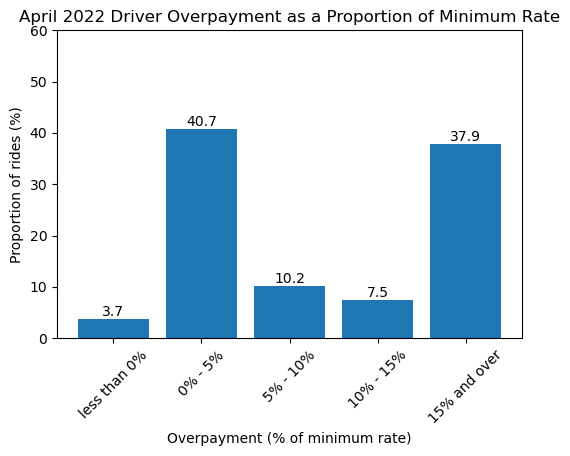

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = rides2022.groupby("perc_over_range")["perc_over_range"].count()*100/len(rides2022["perc_over_range"]))
ax.set_ylim(0, 60)
ax.set_xlabel('Overpayment (% of minimum rate)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('April 2022 Driver Overpayment as a Proportion of Minimum Rate')

In [ ]:
len(rides2022[rides2022.perc_over_min_rate < 0])/len(rides2022)

#### !! Percentage of rides where the driver made 1% or less over the minimum required rate

In [ ]:
len(rides2022[rides2022.perc_over_min_rate <= 0.01])/len(rides2022)

#### !! Percentage of rides where the driver made 10% or less over the minimum required rate

In [ ]:
len(rides2022[rides2022.perc_over_min_rate <= 0.10])/len(rides2022)

#### Percentage of rides where the driver made more than 5% of the minimum required rate

In [ ]:
len(rides2022[rides2022.perc_over_min_rate > 0.05])/len(rides2022)

#### Percentage of rides where the driver made more than 10% of the minimum required rate

In [ ]:
len(rides2022[rides2022.perc_over_min_rate > 0.10])/len(rides2022)

#### Percentage of rides where the driver made more than 20% of the minimum required rate

In [ ]:
len(rides2022[rides2022.perc_over_min_rate > 0.20])/len(rides2022)

#### Distribution of driver pay for rides where the driver made less than the minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate < 0].driver_pay.describe()

#### Distribution of underpayment for rides where the driver made less than the minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate < 0].over_min_rate.describe()

#### (NEW) Distribution of proportion underpaid for rides where the driver made less than the minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate < 0].perc_over_min_rate.describe()

#### Distribution of minimum rate (in dollars) for rides where the driver made less than minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate < 0].min_rate.describe()

#### Distribution of ride length for rides where the driver made less than minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate < 0].trip_miles.describe()

#### (NEW) Distribution of ride length (in minutes) for rides where the driver made less than minimum rate

In [ ]:
rides2022["trip_time_min"] = rides2022["trip_time"]/60
rides2022[rides2022.perc_over_min_rate < 0]["trip_time_min"].describe()

In [15]:
num_underpaid = len(rides2022[rides2022.perc_over_min_rate < 0])

len(rides2022[rides2022.perc_over_min_rate <= -0.01])/num_underpaid

0.010471530476580077

#### Percent of underpaid trips underpaid by 2% or more

In [ ]:
len(rides2022[rides2022.perc_over_min_rate <= -0.02])/num_underpaid

#### Percent of underpaid trips underpaid by 5% or more

In [ ]:
len(rides2022[rides2022.perc_over_min_rate <= -0.05])/num_underpaid

#### Percent of underpaid trips underpaid by 10% or more

In [ ]:
len(rides2022[rides2022.perc_over_min_rate <= -0.10])/num_underpaid

#### Percent of underpaid trips underpaid by 25% or more

In [ ]:
len(rides2022[rides2022.perc_over_min_rate <= -0.25])/num_underpaid

#### Percent of underpaid trips underpaid by 50% or more

In [ ]:
len(rides2022[rides2022.perc_over_min_rate <= -0.50])/num_underpaid

#### Percent of underpaid trips underpaid by 0 - 5%

In [ ]:
len(rides2022[(rides2022.perc_over_min_rate < 0) & (rides2022.perc_over_min_rate >= -0.05)])/num_underpaid

#### Percent of underpaid trips underpaid by 5- 10%

In [ ]:
len(rides2022[(rides2022.perc_over_min_rate < -0.05) & (rides2022.perc_over_min_rate >= -0.1)])/num_underpaid

#### Percent of underpaid trips underpaid by 10 - 15%

In [ ]:
len(rides2022[(rides2022.perc_over_min_rate < -0.1) & (rides2022.perc_over_min_rate >= -.15)])/num_underpaid

#### Percent of underpaid trips underpaid by 15 - 20%

In [ ]:
len(rides2022[(rides2022.perc_over_min_rate < -0.15) & (rides2022.perc_over_min_rate >= -.2)])/num_underpaid

#### Percent of underpaid trips underpaid by 20% or more

In [ ]:
len(rides2022[(rides2022.perc_over_min_rate < -0.20)])/num_underpaid

#### Percent of underpaid trips underpaid by 0 - 0.5%

In [ ]:
len(rides2022[(rides2022.perc_over_min_rate < 0) & (rides2022.perc_over_min_rate >= -0.005)])/num_underpaid

In [16]:
underpaid = pd.DataFrame(data = rides2022[rides2022["perc_over_min_rate"] < 0], columns = ["perc_over_min_rate"]).reset_index(drop = True)

In [17]:
underpaid['perc_under'] = underpaid[underpaid["perc_over_min_rate"] < 0]["perc_over_min_rate"]*(-1)

In [18]:
bin_labels = ['0% - 5%','5% - 10%', '10% - 15%', '15% - 20%', '20% and over']
bins = [0, 0.05, 0.10, 0.15, 0.2, float('inf')]

underpaid['perc_under_range'] = pd.cut(underpaid["perc_under"], bins= bins, labels=bin_labels)

Text(0.5, 1.0, 'April 2022 Driver Underpayment as a Proportion of Minimum Rate')

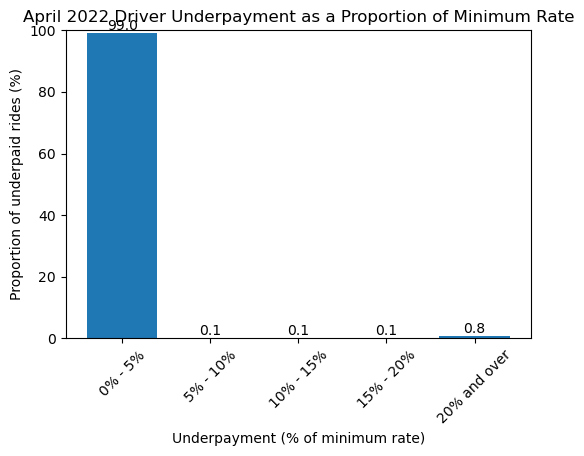

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = underpaid.groupby("perc_under_range")["perc_under_range"].count()*100/len(underpaid["perc_under_range"]))
ax.set_ylim(0, 100)
ax.set_xlabel('Underpayment (% of minimum rate)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of underpaid rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('April 2022 Driver Underpayment as a Proportion of Minimum Rate')

#### Percent of underpaid trips underpaid by \\$0.50 or more

In [ ]:
len(rides2022[(rides2022.over_min_rate <= -0.50)])/num_underpaid

#### Percent of underpaid trips underpaid by \\$1.00 or more

In [ ]:
len(rides2022[(rides2022.over_min_rate <= -1.00)])/num_underpaid

#### Percent of underpaid trips underpaid by \\$1.50 or more

In [ ]:
len(rides2022[(rides2022.over_min_rate <= -1.50)])/num_underpaid

#### Percent of underpaid trips underpaid by \\$2.00 or more

In [ ]:
len(rides2022[(rides2022.over_min_rate <= -2.00)])/num_underpaid

In [ ]:
underpaid_dollar = pd.DataFrame(data = rides2022[rides2022["over_min_rate"] < 0], columns = ["over_min_rate"]).reset_index(drop = True)

In [ ]:
underpaid_dollar['dollar_under'] = underpaid_dollar["over_min_rate"]*(-1)
underpaid_dollar

In [ ]:
bin_labels = ['\$0.00 to \$0.50','\$0.50 to \$1.00', '\$1.00 to \$1.50','\$1.50 to \$2.00','\$2.00 to \$2.50','\$2.50 to \$3.00', '\$3.00 to \$3.50', '\$3.50 or more']
bins = [0, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, float('inf')]

underpaid_dollar['dollar_under_range'] = pd.cut(underpaid_dollar['dollar_under'], bins= bins, labels=bin_labels)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = underpaid_dollar.groupby("dollar_under_range")["dollar_under_range"].count()*100/len(underpaid_dollar["dollar_under_range"]))
ax.set_ylim(0, 100)
ax.set_xlabel('Underpayment ($ under minimum rate)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('April 2022 Driver Underpayment in Dollars')

#### Distribution of driver pay for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate > .2].driver_pay.describe()

#### Distribution of overage (in dollars) for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate > .2]["over_min_rate"].describe()

#### Distribution of minimum rate (in dollars) for rides where the driver made over 20% of the minimum rate

In [ ]:
rides2022[rides2022.perc_over_min_rate > .2]["min_rate"].describe()

#### Distribution of driver pay for rides where the driver made over 20% of the minimum rate (2022 dollars)

In [ ]:
rides2022[rides2022.perc_over_min_rate > .2].driver_pay.describe()

#### !! Percent of trips where overage is more than \$1

In [ ]:
len(rides2022[rides2022['over_min_rate'] > 1])/len(rides2022)

#### !! Percent of trips where overage was \$20 or more

In [ ]:
len(rides2022[rides2022['over_min_rate'] > 20])/len(rides2022)

#### !! Average overage of all trips in dollars

In [ ]:
rides2022['over_min_rate'].describe()

#### !! Average overage of trips that were 10% or less over in dollars

In [ ]:
rides2022[rides2022['perc_over_min_rate'] < .1]['over_min_rate'].describe()

#### !! Average overage of all trips which are over pay rules in dollars

In [ ]:
rides2022[rides2022['over_min_rate'] > 0]['over_min_rate'].describe()

#### Driver Pay min/mile

In [ ]:
rides2022['driver_pay_mile'] = rides2022.driver_pay/rides2022.trip_miles
rides2022['driver_pay_min'] = rides2022.driver_pay/(rides2022.trip_time/60)

In [ ]:
np.mean(rides2022['driver_pay_mile'])

In [ ]:
np.mean(rides2022['driver_pay_min'])

## Passenger Fare Analysis

In [ ]:
# Total passenger fare across all rides

rides2022['base_passenger_fare'].sum()  

#### Distribution of passenger fare (2022 Dollars)

In [ ]:
rides2022.base_passenger_fare.describe()

#### Average fare per minute cost (2022 Dollars)

In [ ]:
np.mean(rides2022['passenger_fare_min'])

#### Average fare per mile cost (2022 Dollars)

In [ ]:
np.mean(rides2022['passenger_fare_mile'])

#### Regression of minutes and miles by passenger fare (In 2022, each additional mile per trip increases the fare by 2.03 dollars and each additional minute per trip increases the fare by 0.47 dollars)



In [ ]:
# convert trip time to minutes
rides2022['trip_time_min'] = rides2022.trip_time/60

In [ ]:
result = sm.ols(formula="base_passenger_fare ~ trip_miles + trip_time_min", data=rides2022).fit()
print(result.params)

## Drivers' earnings compared to passenger fare

In [ ]:
rides2022['perc_earnings_fare'] = rides2022["driver_pay"]/rides2022["base_passenger_fare"]

rides2022["perc_earnings_fare"].describe()

In [ ]:
len(rides2022[rides2022["perc_earnings_fare"] > 1])/len(rides2022["perc_earnings_fare"])

In [ ]:
rides2022[rides2022["perc_earnings_fare"] > 1]["over_min_rate"].describe()

### Plot of proportion of passenger fare that the company takes

In [12]:
rides2022['perc_uber_takes'] = 1 - rides2022["driver_pay"]/rides2022["base_passenger_fare"]

In [13]:
bin_labels = ['None', '0% - 10%','10% - 20%', '20% - 30%', '30% - 40%', '40% and over']
bins = [float('-inf'), 0, 0.10, 0.20, 0.30, 0.40, float('inf')]

rides2022['perc_uber_takes_range'] = pd.cut(rides2022['perc_uber_takes'], bins= bins, labels=bin_labels)

Text(0.5, 1.0, 'April 2022, Proportion of Passenger Fare that the Company Takes')

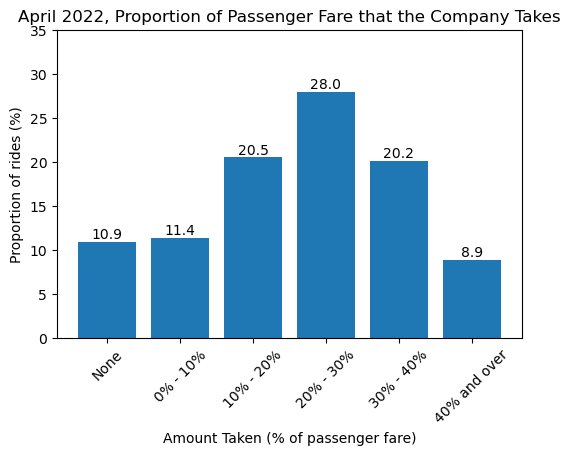

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(x = bin_labels, height = rides2022.groupby("perc_uber_takes_range")["perc_uber_takes_range"].count()*100/len(rides2022["perc_uber_takes_range"]))
ax.set_ylim(0, 35)
ax.set_xlabel('Amount Taken (% of passenger fare)')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Proportion of rides (%)')
ax.bar_label(ax.containers[0], fmt = '%.1f', label_type='edge')
ax.margins(y=0.1)
ax.set_title('April 2022, Proportion of Passenger Fare that the Company Takes')

## Losses on rides

#### Distribution of the percentage losses taken (among rides where a loss was taken)

In [ ]:
rides2022[rides2022['perc_uber_takes'] < 0]['perc_uber_takes'].describe()

#### Distribution of the percentage made over the minimum rate (among rides where a loss was taken)

In [ ]:
rides2022[rides2022['perc_uber_takes'] < 0]['perc_over_min_rate'].describe()

In [ ]:
rides2022[(rides2022['perc_uber_takes'] < 0) & (rides2022['perc_over_min_rate'] < 0)]['perc_over_min_rate'].describe()

In [ ]:
rides2022[(rides2022['perc_uber_takes'] < 0) & (rides2022['perc_over_min_rate'] < 0)]['over_min_rate'].describe()

#### Distribution of the dollar amount made over the minimum rate (among rides where a loss was taken)

In [ ]:
rides2022[rides2022['perc_uber_takes'] < 0]['over_min_rate'].describe()

#### Distribution of the percentage made over the minimum rate (among rides where a loss was not taken)

In [ ]:
rides2022[rides2022['perc_uber_takes'] >= 0]['perc_over_min_rate'].describe()

#### Distribution of the dollar amount made over the minimum rate (among rides where a loss was not taken)

In [ ]:
rides2022[rides2022['perc_uber_takes'] >= 0]['over_min_rate'].describe()

#### Percentage of rides that made under the minimum rate when a loss was taken

In [ ]:
len(rides2022[(rides2022['perc_uber_takes'] < 0) & (rides2022['perc_over_min_rate'] < 0)]['perc_over_min_rate'])/ len(rides2022[rides2022['perc_uber_takes'] < 0]['perc_over_min_rate'])

## Trip lengths

In [ ]:
rides2022["trip_time_min"].describe()

In [ ]:
rides2022["trip_miles"].describe()